2025

In [4]:
%pip install numpy pandas matplotlib seaborn scikit-learn

In [19]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Cargar y unir datasets

In [6]:
df1 = pd.read_csv("DATAFLORIDA2023.csv")
df2 = pd.read_csv("DATAFLORIDA2024.csv")
df3 = pd.read_csv("DATAFLORIDA2025.csv")

df = pd.concat([df1, df2, df3], ignore_index=True)

In [17]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           21365 non-null  datetime64[ns]
 1   Source                         21365 non-null  object        
 2   Site ID                        21365 non-null  int64         
 3   POC                            21365 non-null  int64         
 4   Daily Mean PM10 Concentration  21365 non-null  int64         
 5   Units                          21365 non-null  object        
 6   Daily AQI Value                21365 non-null  int64         
 7   Local Site Name                21365 non-null  object        
 8   Daily Obs Count                21365 non-null  int64         
 9   Percent Complete               21365 non-null  float64       
 10  AQS Parameter Code             21365 non-null  int64         
 11  AQS Parameter D

In [28]:
df.describe()

,Date,Site ID,POC,Daily Mean PM10 Concentration,Daily AQI Value,Daily Obs Count,Percent Complete,AQS Parameter Code,Method Code,CBSA Code,State FIPS Code,County FIPS Code,Site Latitude,Site Longitude,Year,Month,Day,Days_Since_Start
count,21365,2.136500e+04,21365.000000,21365.000000,21365.000000,21365.0,21365.0,21365.0,19560.000000,21365.000000,21365.0,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000,21365.000000
mean,2024-05-25 10:12:35.890475008,1.207465e+08,2.333536,18.355441,16.955722,1.0,100.0,81102.0,371.357311,35103.252048,12.0,74.500304,28.065126,-81.894805,2023.943272,5.988860,15.629722,510.425415
min,2023-01-01 00:00:00,1.200900e+08,1.000000,0.000000,0.000000,1.0,100.0,81102.0,79.000000,15980.000000,12.0,9.000000,25.478230,-87.203550,2023.000000,1.000000,1.000000,0.000000
25%,2023-09-30 00:00:00,1.203300e+08,1.000000,13.000000,12.000000,1.0,100.0,81102.0,79.000000,33100.000000,12.0,33.000000,27.172458,-82.479722,2023.000000,3.000000,8.000000,272.000000
50%,2024-06-02 00:00:00,1.208660e+08,3.000000,16.000000,15.000000,1.0,100.0,81102.0,239.000000,36740.000000,12.0,86.000000,27.895856,-81.635396,2024.000000,6.000000,16.000000,518.000000
75%,2025-01-29 00:00:00,1.210330e+08,3.000000,21.000000,19.000000,1.0,100.0,81102.0,639.000000,38940.000000,12.0,103.000000,29.206667,-80.483739,2025.000000,9.000000,23.000000,759.000000
max,2025-09-17 00:00:00,1.212750e+08,4.000000,177.000000,112.000000,1.0,100.0,81102.0,639.000000,45300.000000,12.0,127.000000,30.525367,-80.092778,2025.000000,12.000000,31.000000,990.000000
std,NaN,3.730001e+05,0.902243,9.039230,8.079935,0.0,0.0,0.0,249.747890,8083.550251,0.0,37.253484,1.467602,1.774615,0.786912,3.311394,8.792959,282.615439


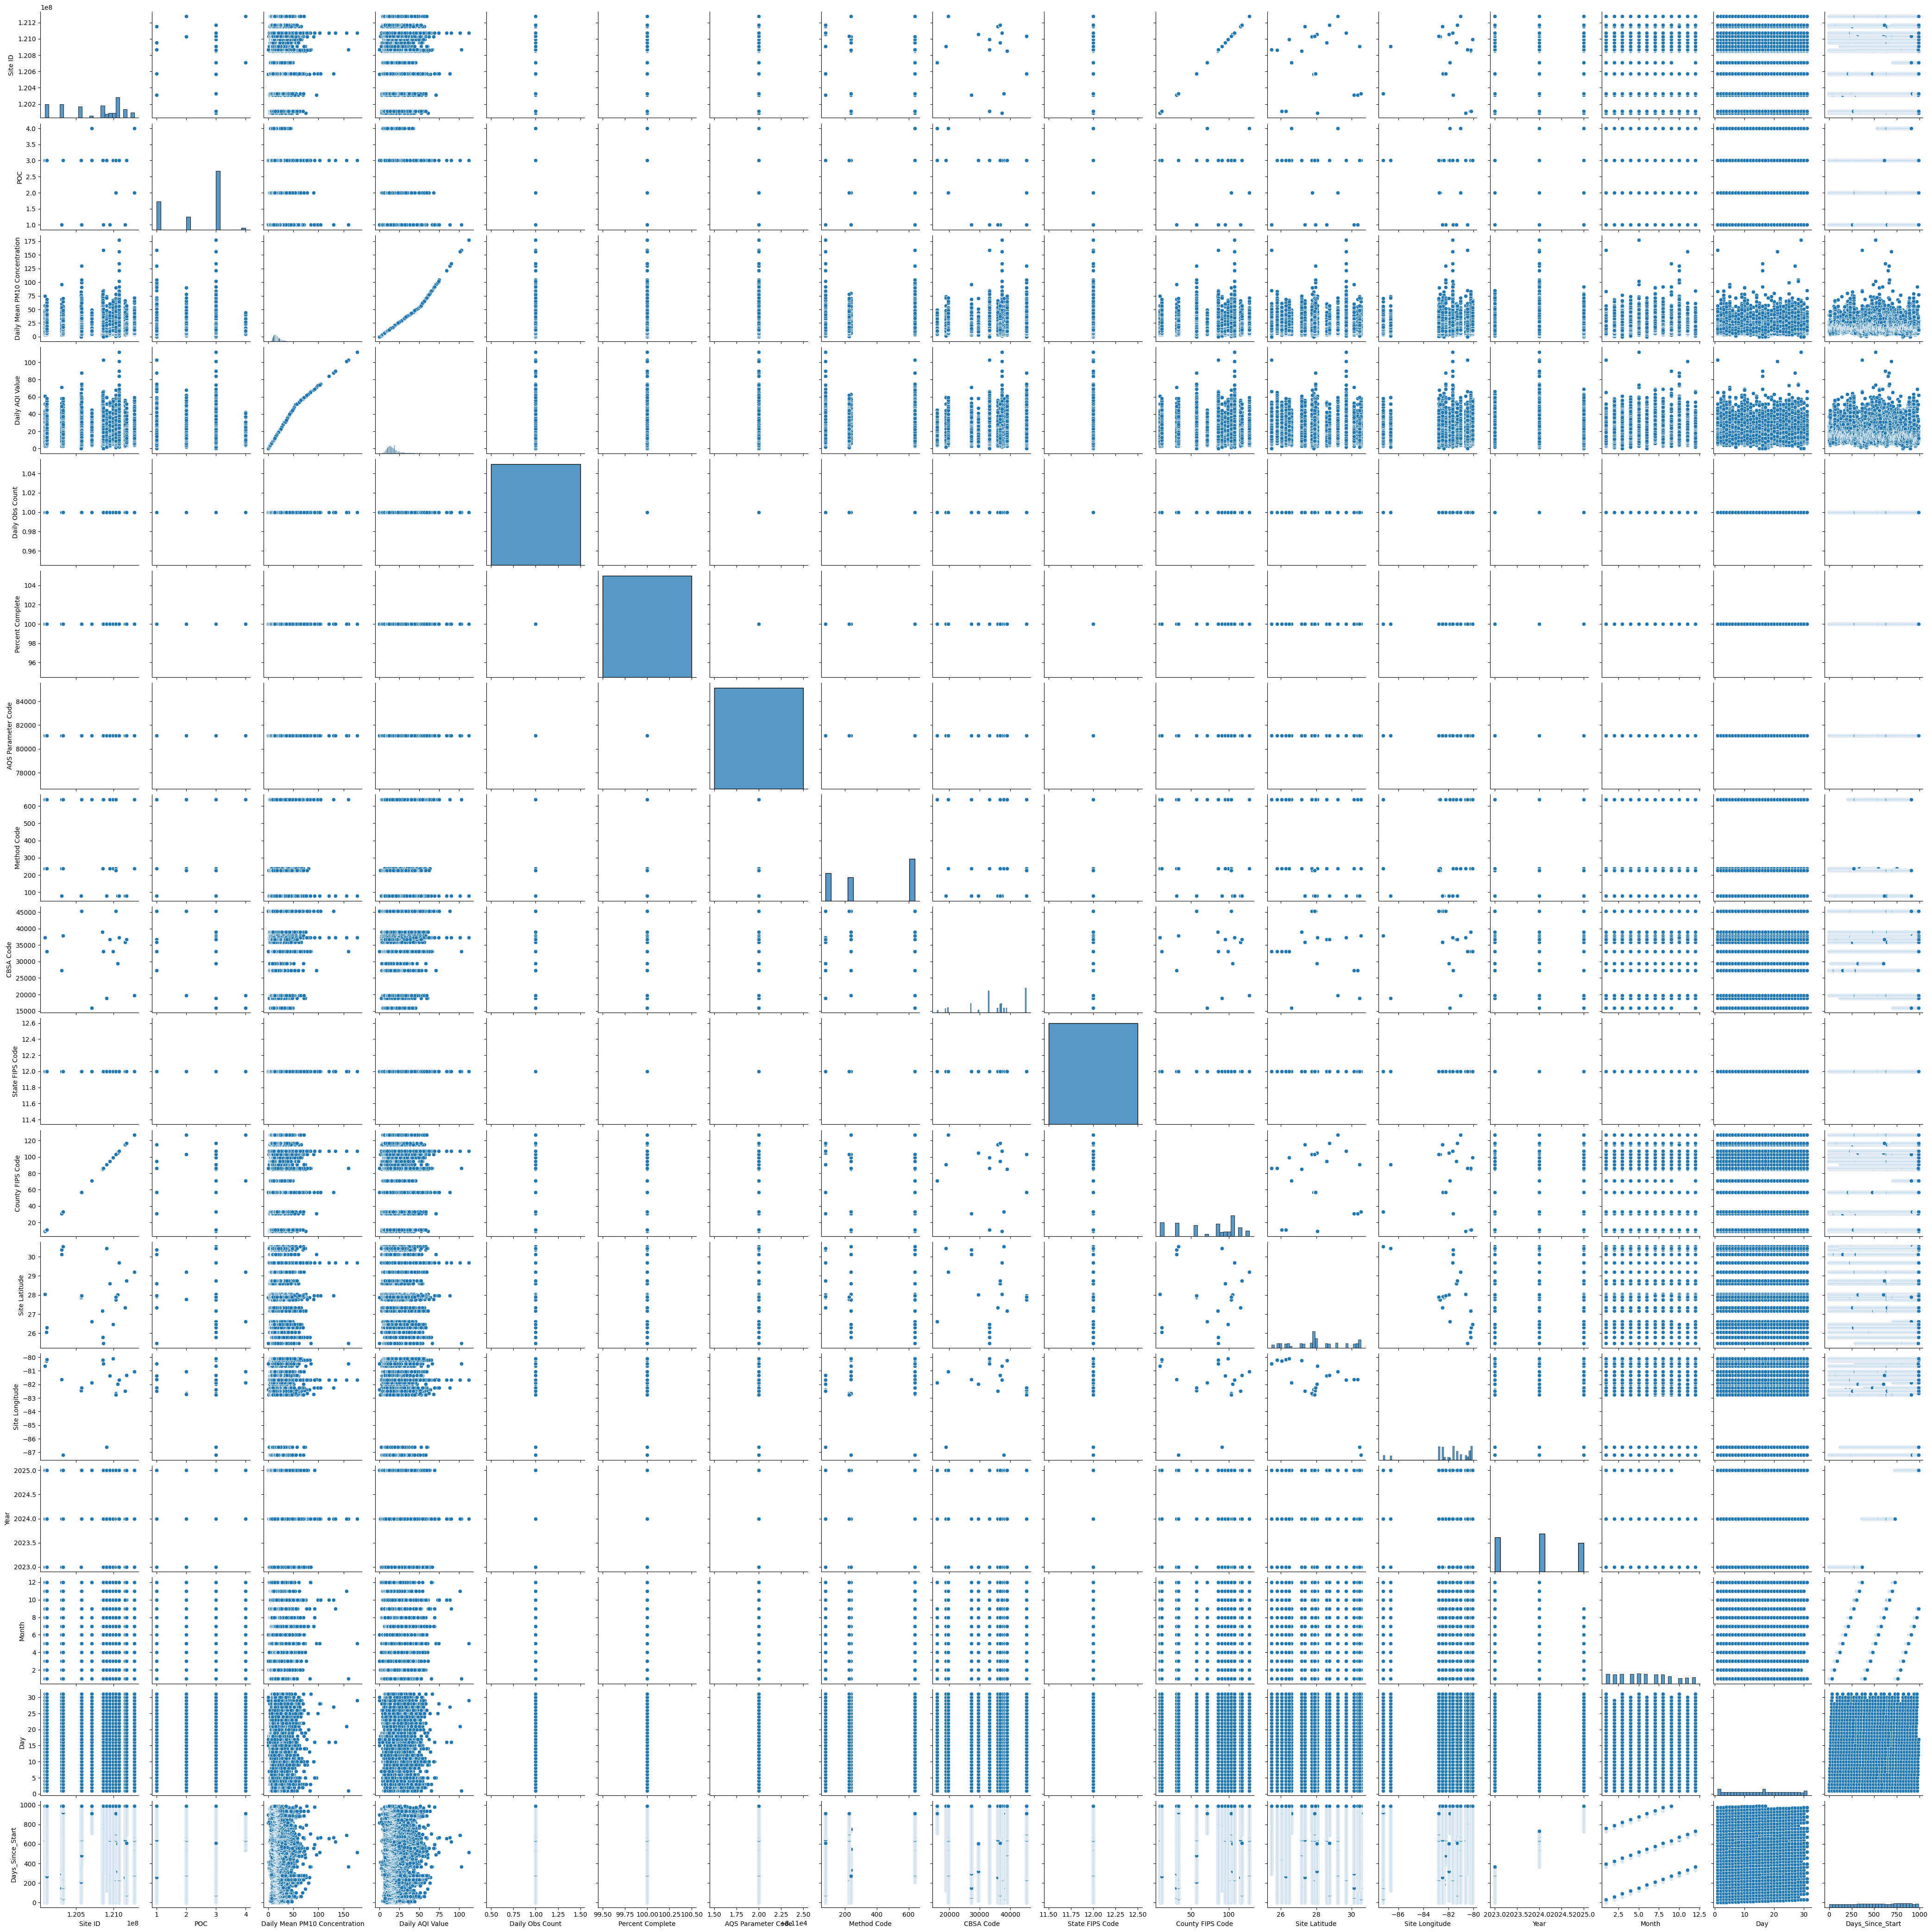

In [22]:

sns.pairplot(df)

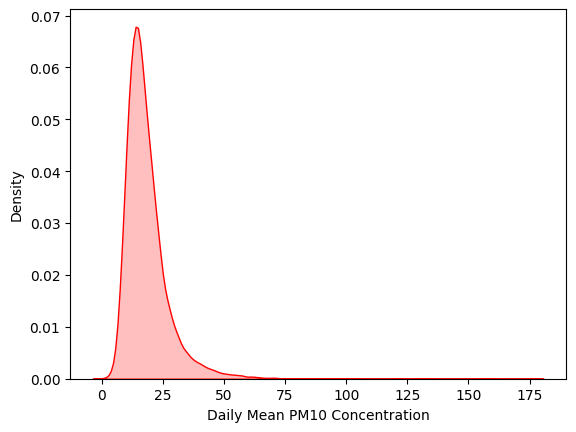

In [27]:
sns.kdeplot(df['Daily Mean PM10 Concentration'], fill=True, color="red")
plt.show()




# 2. Procesar fechas

In [7]:
df["Date"] = pd.to_datetime(df["Date"])
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Days_Since_Start"] = (df["Date"] - df["Date"].min()).dt.days

# 3. Definir target

In [8]:
target = "Daily Mean PM10 Concentration"

# 4. Variables categóricas y numéricas

In [9]:
cat_cols = ["Source", "Units", "Local Site Name",
            "AQS Parameter Description", "CBSA Name",
            "State", "County"]

num_cols = ["Days_Since_Start", "Month", "Day", "Year",
            "Percent Complete", "AQS Parameter Code",
            "Method Code", "Site Latitude", "Site Longitude"]


# 5. Separar  (2023+2024) Y (2025)

In [10]:
df_train = df[df["Year"].isin([2023, 2024])]
df_test = df[df["Year"] == 2025]

y_train = df_train[target]
y_test = df_test[target]


In [11]:
# --- One-hot encoding ---
train_cat = pd.get_dummies(df_train[cat_cols], drop_first=True)
test_cat = pd.get_dummies(df_test[cat_cols], drop_first=True)

In [12]:
# Alinear columnas para que coincidan
train_cat, test_cat = train_cat.align(test_cat, join="left", axis=1, fill_value=0)

# Combinar
X_train = pd.concat([df_train[num_cols], train_cat], axis=1)
X_test = pd.concat([df_test[num_cols], test_cat], axis=1)

# 6. Imputar valores faltantes

In [13]:
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# 7. Modelo lineal

In [14]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_2025 = model.predict(X_test)

# 8. Métricas

In [15]:
mae = mean_absolute_error(y_test, y_pred_2025)
mse = mean_squared_error(y_test, y_pred_2025)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_2025)

print("Evaluación en datos 2025:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Evaluación en datos 2025:
MAE: 5.91
MSE: 66.55
RMSE: 8.16
R²: 0.15
